In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time


import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SMOTENC


import sklearn
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, \
    classification_report, multilabel_confusion_matrix, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

from src.config import Config
from src.analysis import Analysis
from src.train import Train

analysis = Analysis()
train = Train()

pd.set_option('display.max_rows', 500)

ImportError: cannot import name 'RandomSearchCV' from 'sklearn.model_selection' (c:\projects\2021\multiclass_classification\python3.7_multiclass\lib\site-packages\sklearn\model_selection\__init__.py)

In [8]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    
def cm_single(y_test, y_pred, fontsize=14):
    
    labels = ["".join("c" + str(i[0])) for i in pd.DataFrame(y_test).value_counts().index]
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    fig = plt.figure(figsize=(6,4))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    heatmap.set_title("Confusion Matrix for Binary Label" )
    plt.show()
        

def cm_plot(y_test, y_pred, nrow=3, ncol=2):
    
    labels = ["".join("c" + str(i[0])) for i in pd.DataFrame(y_test).value_counts().index]
    cm = multilabel_confusion_matrix(y_test, y_pred)
    if nrow == 1: 
        figsize = (8,4)
    else:
        figsize = (12,7)
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
    if nrow == 3:
        fig.delaxes(ax[2,1])
    fig.tight_layout()
    plt.show()
    
def pr_auc(X_test, y_test, n_classes):
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 7))
    
    # Precision-Recall Curve
    y_score = model.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[*range(n_classes)])
    precision = dict()
    recall = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
        ax[0].plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    no_skill = len(y_test[y_test==1]) / len(y_test)
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].legend(loc="best")
    ax[0].set_title("precision vs. recall curve")

    # ROC curve
    fpr = dict()
    tpr = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        ax[1].plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
    ax[1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    ax[1].set_xlabel("false positive rate")
    ax[1].set_ylabel("true positive rate")
    ax[1].legend(loc="best")
    ax[1].set_title("ROC curve")
    
    fig.tight_layout()
    
def class_count(y_test, y_pred):
    true = pd.DataFrame(y_test.value_counts())
    pred = pd.DataFrame(list(np.unique(y_pred, return_counts=True)[1]))
    pred.index = list(np.unique(y_pred, return_counts=True)[0])
    final = pd.concat([true, pred], axis=1).rename(columns={0:"pred"})
    display(final)


In [9]:
combined_df1 = analysis.read_file("./data/combined_dataset1.csv")
combined_df2 = analysis.read_file("./data/combined_dataset2.csv")
combined_df3 = analysis.read_file("./data/combined_dataset3.csv")
combined_df4 = analysis.read_file("./data/combined_dataset4.csv")

Reading file: ./data/combined_dataset1.csv ...
Data import complete for file: ./data/combined_dataset1.csv ...
Reading file: ./data/combined_dataset2.csv ...
Data import complete for file: ./data/combined_dataset2.csv ...
Reading file: ./data/combined_dataset3.csv ...
Data import complete for file: ./data/combined_dataset3.csv ...
Reading file: ./data/combined_dataset4.csv ...
Data import complete for file: ./data/combined_dataset4.csv ...


In [10]:
# Subset 1 and Feature Selection
X_train, X_test, y_train, y_test = train.traintest_split(combined_df1, test_size=0.3)
ANOVA_fs, chi2_fs = train.feature_selection(X_train, y_train, num_cols="all")

In [26]:
from imblearn.over_sampling import SMOTE
def oversampling(X_train, y_train, plot=False):
    
    oversample = SMOTE(random_state=123)
    X_otrain,y_otrain = oversample.fit_resample(X_train,y_train)
    if plot:
        display(y_otrain.value_counts(normalize=True).plot.pie())
        
    return X_otrain, y_otrain

<AxesSubplot:ylabel='target'>

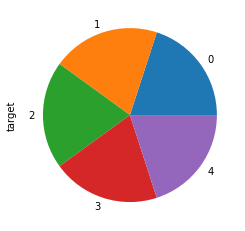

In [12]:
# Subset 1 and Baseline Model
feature_list = list(ANOVA_fs["features_selected"].values) + list(chi2_fs["features_selected"].values) + ["target"]
data = combined_df1.loc[:, combined_df1.columns.isin(feature_list)]
cols = ["12", "64", "95", "113"]
data[cols] = data[cols].astype("int64")
X_train, X_test, y_train, y_test = train.traintest_split(data, test_size=0.3)
X_otrain, y_otrain = oversampling(X_train, y_train, plot=True)

<AxesSubplot:ylabel='target'>

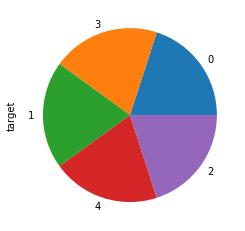

In [27]:
# Subset 2 and Baseline Model
X_train2, X_test2, y_train2, y_test2 = train.traintest_split(combined_df2, test_size=0.3)
ANOVA_fs2, chi2_fs2 = train.feature_selection(X_train2, y_train2, num_cols="all")
feature_list = list(ANOVA_fs2["features_selected"].values) + list(chi2_fs2["features_selected"].values) + ["target"]
data = combined_df2.loc[:, combined_df2.columns.isin(feature_list)]
cols = data.select_dtypes("category").columns
data[cols] = data[cols].astype("int64")
X_train2, X_test2, y_train2, y_test2 = train.traintest_split(data, test_size=0.3)
X_otrain2, y_otrain2 = oversampling(X_train2, y_train2, plot=True)

In [28]:
y_train2.shape

(5732,)

<AxesSubplot:ylabel='target'>

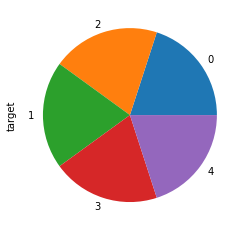

In [29]:
# Subset 3 and Baseline Model
X_train3, X_test3, y_train3, y_test3 = train.traintest_split(combined_df3, test_size=0.3)
ANOVA_fs3, chi2_fs3 = train.feature_selection(X_train3, y_train3, num_cols="all")
feature_list = list(ANOVA_fs3["features_selected"].values) + list(chi2_fs3["features_selected"].values) + ["target"]
data = combined_df3.loc[:, combined_df3.columns.isin(feature_list)]
cols = data.select_dtypes("category").columns
data[cols] = data[cols].astype("int64")
X_train3, X_test3, y_train3, y_test3 = train.traintest_split(data, test_size=0.3)
X_otrain3, y_otrain3 = oversampling(X_train3, y_train3, plot=True)

<AxesSubplot:ylabel='target'>

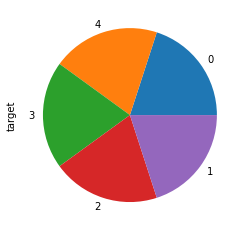

In [30]:
# Subset 4 and Baseline Model
X_train4, X_test4, y_train4, y_test4 = train.traintest_split(combined_df4, test_size=0.3)
ANOVA_fs4, chi2_fs4 = train.feature_selection(X_train4, y_train4, num_cols="all")
feature_list = list(ANOVA_fs4["features_selected"].values) + list(chi2_fs4["features_selected"].values) + ["target"]
data = combined_df4.loc[:, combined_df4.columns.isin(feature_list)]
cols = data.select_dtypes("category").columns
data[cols] = data[cols].astype("int64")
X_train4, X_test4, y_train4, y_test4 = train.traintest_split(data, test_size=0.3)
X_otrain4, y_otrain4 = oversampling(X_train4, y_train4, plot=True)

# Baseline Model

In [31]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)

,target,pred
0,2972,3020
1,30,2
2,18,18
3,16,1
4,8,3


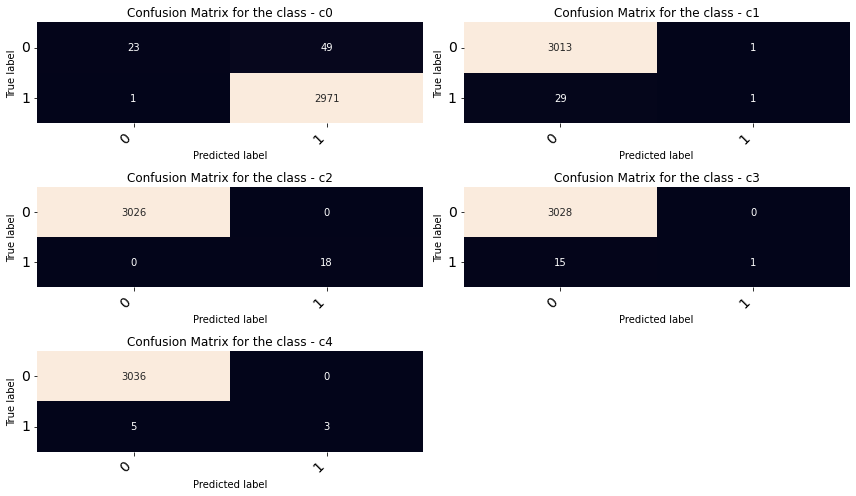

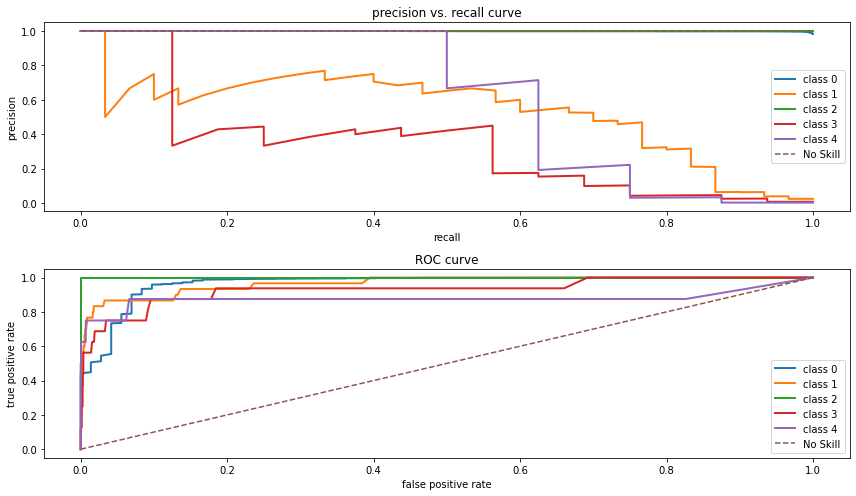

In [89]:
filename = './models/models_new/baseline_model_rf.sav'
pickle.dump(rf_model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
class_count(y_test, y_pred)
cm_plot(y_test, y_pred)
pr_auc(X_test, y_test, 5)

In [94]:
# do grid search cv
tic = time.clock()
rfc = RandomForestClassifier(random_state=123)
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
toc = time.clock()
duration = toc - tic
print(duration)

KeyboardInterrupt: 

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=123).fit(X_otrain, y_otrain)
filename = './models/models_new/baseline_model_rf_tuned.sav'
pickle.dump(rf_model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)
class_count(y_test, y_pred)
cm_plot(y_test, y_pred)
pr_auc(X_test, y_test, 5)

# Model Improvement